# 1. Import and connection

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import matplotlib.image as mpimg
import cv2
import random
from google.colab.patches import cv2_imshow

In [ ]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 2. Data

## 2.1 Functions

In [ ]:
# parametes mean & std
imagenet_mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
imagenet_std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [ ]:
# Display image
def display_img(img):
    # Read the image
    image_min = np.min(img)
    image_max = np.max(img)
    image = (img - image_min) / (image_max - image_min)
    image = (image * 255)
    # Display the image
    cv2_imshow(image)
    cv2.waitKey(1)
    cv2.destroyAllWindows()

In [ ]:
def convert_to_lowercase(text):
    lowercase_text = ""
    for char in text:
        if char == 'G':
            lowercase_text += 'g'
        else:
            lowercase_text += char.lower()
    return lowercase_text

def label_text2int(t):
    la = convert_to_lowercase(t)
    if( la == 'rbc' ): return 1
    elif( la == 'neutrophil' ): return 2
    elif( la == 'eosinophil' ): return 3
    elif( la == 'basophil' ): return 4
    elif( la == 'monocyte' ): return 5
    elif( la == 'Lymphocyte' ): return 6
    else: return 0
    return 0

def label_int2text(i):
    if( i == 1 ): return 'RBC'
    elif( i == 2 ): return 'NEUTROPHIL'
    elif( i == 3 ): return 'EOSINOPHIL'
    elif( i == 4 ): return 'BASOPHIL'
    elif( i == 5 ): return 'MONOCYTE'
    elif( i == 6 ): return 'LYMPHOCYTE'
    else: return 'BACKGROUND'
    return 'BACKGROUND'

In [ ]:
# Read data
def display_data(anno, img):

    box = anno['boxes']
    clas = anno['labels']

    image_min = np.min(img)
    image_max = np.max(img)
    image = (img - image_min) / (image_max - image_min)
    image = (image * 255)

    for i in range(len(box)):
        xmin = int(box[i][0])
        ymin = int(box[i][1])
        xmax = int(box[i][2])
        ymax = int(box[i][3])
        label1 = label_int2text(clas[i])
        label2 = '({}, {})'.format(xmin, ymin)
        # Draw the bounding qbox on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)
        # Draw label
        cv2.putText(image, label1, (xmin + 5, ymin + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
        cv2.putText(image, label2, (xmin + 5, ymin + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    # Display the image
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
# Read data
def display_data_out(anno, img):

    box = anno['boxes']
    clas = anno['labels']
    scor = anno['scores']

    image_min = np.min(img)
    image_max = np.max(img)
    image = (img - image_min) / (image_max - image_min)
    image = (image * 255)

    for i in range(len(box)):
        if( scor[i] > 0.3 ):
            xmin = int(box[i][0])
            ymin = int(box[i][1])
            xmax = int(box[i][2])
            ymax = int(box[i][3])
            label1 = label_int2text(clas[i])
            label2 = str(round(scor[i].item(), 2))
            # Draw the bounding qbox on the image
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)
            # Draw label
            cv2.putText(image, label1, (xmin + 5, ymin + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
            cv2.putText(image, label2, (xmin + 5, ymin + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    # Display the image
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## 2.2 load and display

In [ ]:
import pickle
# Load annotations
with open('/content/drive/MyDrive/VKU_Medical_Blood/Faster_RCNN/Annotations/JSON Type/xy_xy.pkl', 'rb') as f:
    annotations = pickle.load(f)
print(annotations[0])

{'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]), 'boxes': tensor([[ 360.,  598.,  527.,  773.],
        [ 128.,  543.,  295.,  718.],
        [ 900.,  588., 1067.,  763.],
        [ 675.,  583.,  855.,  762.],
        [ 267.,  120.,  408.,  295.],
        [   8.,  558.,  150.,  733.],
        [ 900.,   65., 1067.,  248.],
        [ 638.,    2.,  840.,  188.],
        [  15.,  137.,  180.,  280.],
        [ 113.,  353.,  275.,  577.],
        [ 285.,  302.,  440.,  470.],
        [ 443.,  303.,  815.,  615.]])}


In [ ]:
# Load images
images = np.load('/content/drive/MyDrive/VKU_Medical_Blood/Faster_RCNN/images/X.npy')

print(images.shape)

(343, 800, 1066, 3)


In [ ]:
# Assert if length image and annotations is not equal
assert len(images) == len(annotations), "Length of images and annotations is not equal {} --> {}".format(len(images), len(annotations))

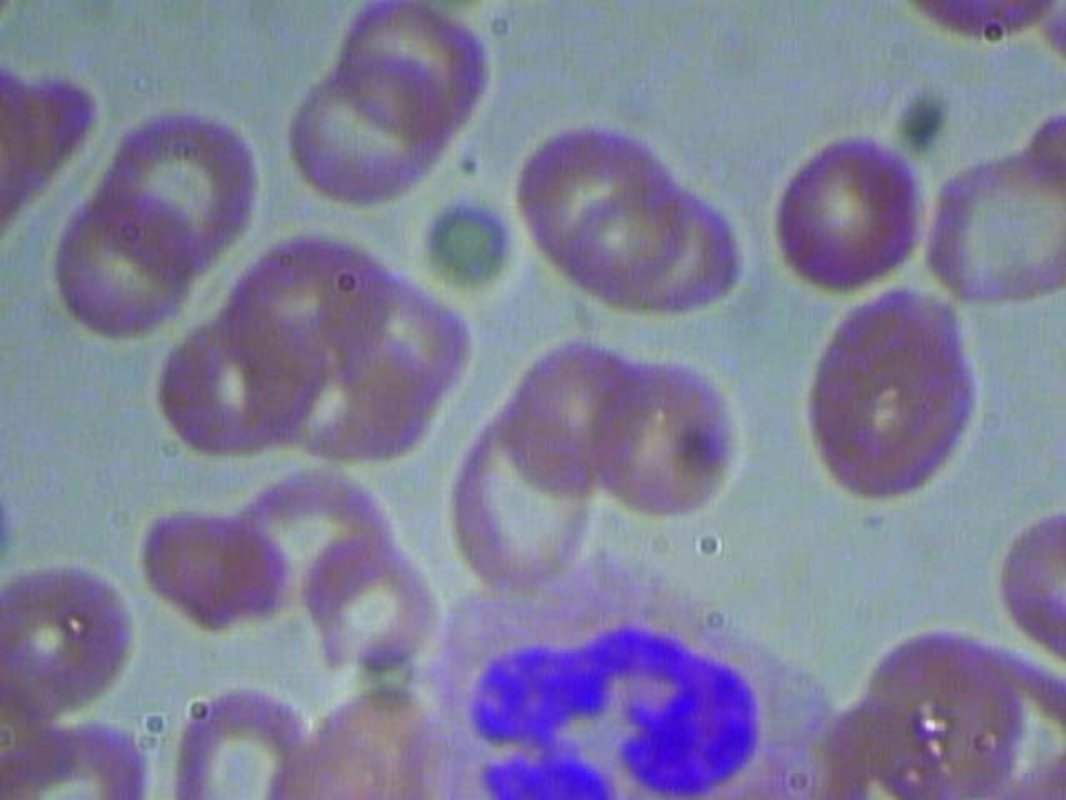

In [ ]:
# display image
display_img(images[279])

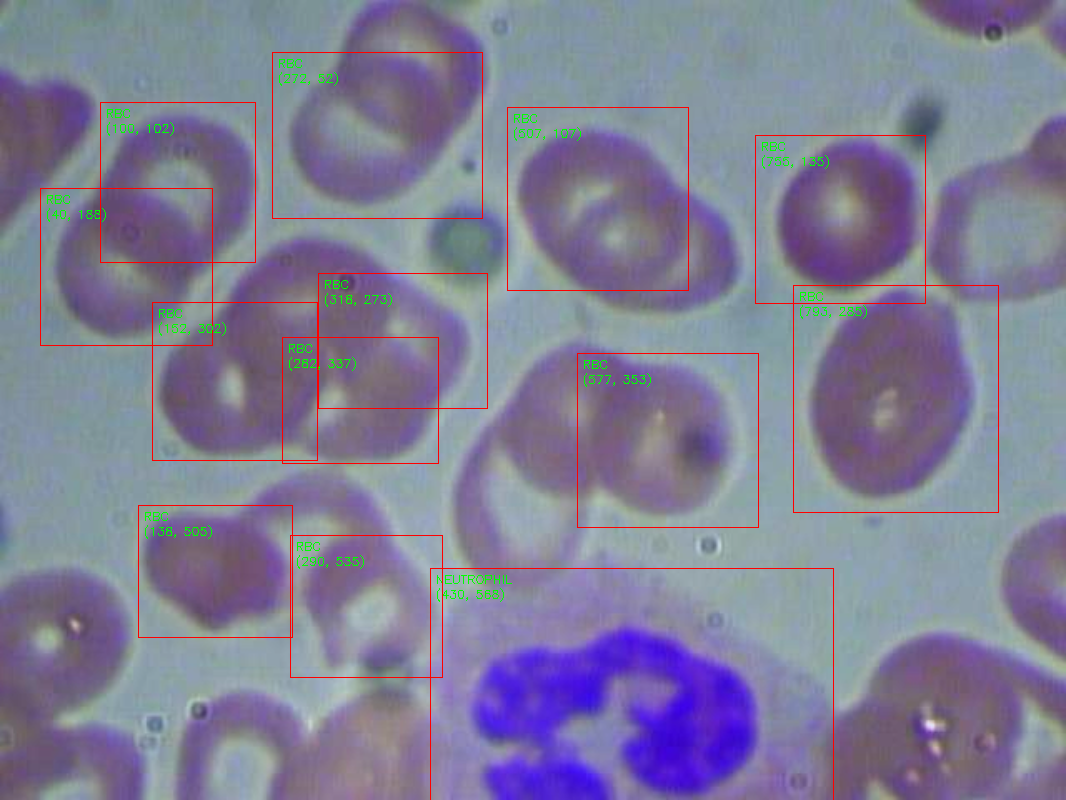

In [ ]:
# display annotations
display_data(annotations[279], images[279])

# 3. Model

In [ ]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# load model
model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
model.load_state_dict(torch.load("/content/drive/MyDrive/VKU_Medical_Blood/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth"))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:02<00:00, 32.4MB/s]


<All keys matched successfully>

In [ ]:
# Define output class
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_class = 7 # 0 background + num class = 1 + 6 = 7 (start 1)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_class)

In [ ]:
# display last layer - output
print('Number class output:', model.roi_heads.box_predictor.cls_score.out_features)

Number class output: 7


In [ ]:
# display summary model
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=7, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=28, bias=True)
  )
)

In [ ]:
lr = 0.005

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)

In [ ]:
import time

# parameters
total_train_loss = []
total_train_acc = []

count_lr = 1
count_stop = 1
nums_epoch = 60
batch_size = 32
num_batch_train = int(len(images) / batch_size)

images = torch.tensor(images)
images = images.permute(0, 3, 1, 2)

for epoch in range(nums_epoch):
    # Start time
    start = time.time()
    print(f'Epoch {epoch + 1}  ==>  ', end='')


    # parameters
    train_loss = []
    val_loss = []


    # Training
    model.train(True)
    for batch in range(num_batch_train+1):
        # Load data to batch
        if( batch == num_batch_train ):
            print('-')
            img_temp = images[batch*batch_size :]
            anno_temp = annotations[batch*batch_size :]
        else:
            print('-', end='')
            img_temp = images[batch*batch_size : (batch+1)*batch_size]
            anno_temp = annotations[batch*batch_size : (batch+1)*batch_size]

        # Data to device
        img_temp = list(image.to(device) for image in img_temp)

        anno_temp = [{k: v.to(device) for k, v in t.items()} for t in anno_temp]

        # train model
        optimizer.zero_grad()
        loss_dict = model(img_temp, anno_temp)
        # calculate sum loss
        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())
        # backward and update weight
        losses.backward()
        optimizer.step()
    # calcualte mean loss
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)


    # End time
    end = time.time()
    training_time = end - start


    # display information
    print(f'\tLoss train is {epoch_train_loss}')
    if( epoch >=1 ):
        if( total_train_loss[epoch-1] > epoch_train_loss ):
            print('\tTrain loss decreased {:.5f} --> {:.5f}'.format(total_train_loss[epoch-1], epoch_train_loss))
        else:
            count_lr += 1
    # down learning rate
    if( count_lr > 3 ):
        count_lr = 1
        # Decrease the learning rate
        lr /= 2
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    print('\tTime trained is {:.0f} m {:.0f}'.format(training_time // 60, training_time % 60))
    print('\tLearning rate = {}\n'.format(lr))


# Save model
torch.save(model, '/content/drive/MyDrive/VKU_Medical_Blood/Faster_RCNN/model.pth')

In [ ]:
model.eval()


out = model(images[279:280].to(device))

print(out)

[{'boxes': tensor([[7.6294e+02, 1.2716e+02, 9.2713e+02, 2.9378e+02],
        [5.7912e+02, 3.5381e+02, 7.5464e+02, 5.2879e+02],
        [5.0428e+02, 1.1804e+02, 6.9445e+02, 2.9456e+02],
        [1.3684e+02, 4.9936e+02, 2.9171e+02, 6.3628e+02],
        [4.4865e+01, 1.8851e+02, 2.1057e+02, 3.4226e+02],
        [7.9289e+02, 2.8122e+02, 9.9032e+02, 5.0711e+02],
        [2.7836e+02, 4.6597e+01, 4.6403e+02, 2.0940e+02],
        [4.1542e+02, 5.6886e+02, 8.2390e+02, 7.9201e+02],
        [2.9782e+02, 5.2758e+02, 4.3650e+02, 6.8352e+02],
        [8.7409e+01, 1.0231e+02, 2.6551e+02, 2.6452e+02],
        [1.5263e+02, 3.0368e+02, 3.2645e+02, 4.6028e+02],
        [5.0197e+02, 3.3405e+02, 6.4557e+02, 4.9235e+02],
        [4.3590e+02, 4.1009e+02, 6.0101e+02, 5.9000e+02],
        [7.9819e-01, 5.5725e+02, 1.4117e+02, 7.2736e+02],
        [9.2356e+02, 1.3211e+02, 1.0633e+03, 3.1103e+02],
        [6.5536e+01, 1.5041e+02, 2.4021e+02, 2.9524e+02],
        [3.2877e+02, 0.0000e+00, 4.9750e+02, 1.4050e+02],
   

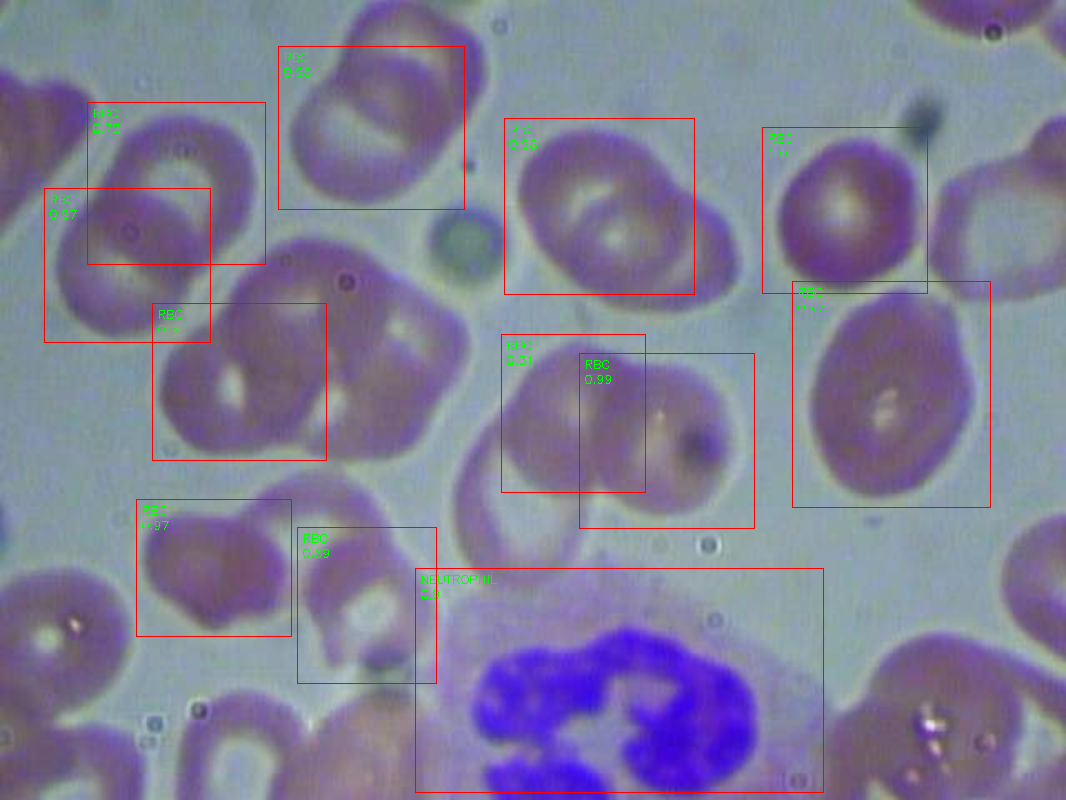

In [ ]:
img = images[279]
img = img.permute(1, 2, 0)
img = np.array(img)

box = out[0]['boxes']
lab = out[0]['labels']

display_data_out(out[0], img)

In [ ]:
print(out[0]['scores'][0])

tensor(0.9975, device='cuda:0', grad_fn=<SelectBackward0>)
